In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 22.9 MB/s eta 0:00:00


In [4]:
print("Loading BBBP dataset...")

Loading BBBP dataset...


In [5]:
dataset=MoleculeNet(root=".",name="BBBP")

Processing...
/usr/local/lib/python3.12/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/usr/local/lib/python3.12/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/usr/local/lib/python3.12/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 'Cc1nc(sc1)\[NH]=C(\N)N' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/usr/local/lib/python3.12/dist-packages/torch_geometric/datasets/molecule_net.py:213: UserWarning: Skipping molecule 's1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N' since it resulted in zero atoms
  warnings.warn(f"Skipping molecule '{smiles}' since it "
/

In [6]:
print(f"Dataset loaded successfully. Number of graphs: {len(dataset)}")

Dataset loaded successfully. Number of graphs: 2039


In [7]:
data_sample=dataset[0]

In [8]:
print("\n--- Sample Data Point ---")
print(data_sample)


--- Sample Data Point ---
Data(x=[20, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12', y=[1, 1])


In [9]:
print(f"Number of nodes (atoms): {data_sample.num_nodes}")
print(f"Number of edges (bonds): {data_sample.num_edges}")
print(f"Node features shape: {data_sample.x.shape}") # [num_nodes, num_node_features]
print(f"Edge features shape: {data_sample.edge_attr.shape}") # [num_edges, num_edge_features]
print(f"Graph label (bioactivity): {data_sample.y}") # y is our target

Number of nodes (atoms): 20
Number of edges (bonds): 40
Node features shape: torch.Size([20, 9])
Edge features shape: torch.Size([40, 3])
Graph label (bioactivity): tensor([[1.]])


In [10]:
dataset=dataset.shuffle()

In [11]:
train_dataset=dataset[:int(len(dataset)*0.8)]
val_dataset=dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset=dataset[int(len(dataset)*0.9):]

In [12]:
print(f"\nTraining set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 1631
Validation set size: 204
Test set size: 204


In [13]:
# Create data loaders for batching
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_heads):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        self.gat1 = GATConv(num_node_features, hidden_channels, heads=num_heads)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.gat3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # THE FIX: Convert node features to float, as dropout requires float input.
        x = x.float()

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat3(x, edge_index)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin(x)
        return x

model = GAT(num_node_features=dataset.num_node_features, hidden_channels=64, num_heads=8)
print("\n--- Model Architecture ---")
print(model)


--- Model Architecture ---
GAT(
  (gat1): GATConv(9, 64, heads=8)
  (gat2): GATConv(512, 64, heads=8)
  (gat3): GATConv(512, 64, heads=1)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = torch.nn.BCEWithLogitsLoss()

def train(loader):
    model.train()
    total_loss = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(loader)


In [16]:
def test(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            all_preds.extend(pred.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    # Calculate metrics
    roc_auc = roc_auc_score(all_labels, all_preds)
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
    return accuracy, roc_auc

In [17]:
# Let's start the training loop!
# This loop now works correctly because it calls the right functions.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
train_losses = []
val_accuracies = []
print("\n--- Starting Training ---")
for epoch in range(1, 301):
    train_loss = train(train_loader)
    val_acc, val_roc_auc = test(val_loader)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    scheduler.step(train_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

print("\n--- Training Complete ---")


--- Starting Training ---
Epoch: 010, Train Loss: 0.5391, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 020, Train Loss: 0.5235, Val Accuracy: 0.7745, Val ROC-AUC: 0.4969
Epoch: 030, Train Loss: 0.5175, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 040, Train Loss: 0.5213, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 050, Train Loss: 0.5124, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 060, Train Loss: 0.5134, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 070, Train Loss: 0.5195, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 080, Train Loss: 0.5192, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 090, Train Loss: 0.5173, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 100, Train Loss: 0.5181, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 110, Train Loss: 0.5184, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 120, Train Loss: 0.5184, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 130, Train Loss: 0.5119, Val Accuracy: 0.7794, Val ROC-AUC: 0.5000
Epoch: 140,

In [20]:
# --- 6. Final Evaluation ---
test_acc, test_roc_auc = test(test_loader)
print(f"\n--- Final Test Results ---")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")


--- Final Test Results ---
Test Accuracy: 0.7647
Test ROC-AUC: 0.5102


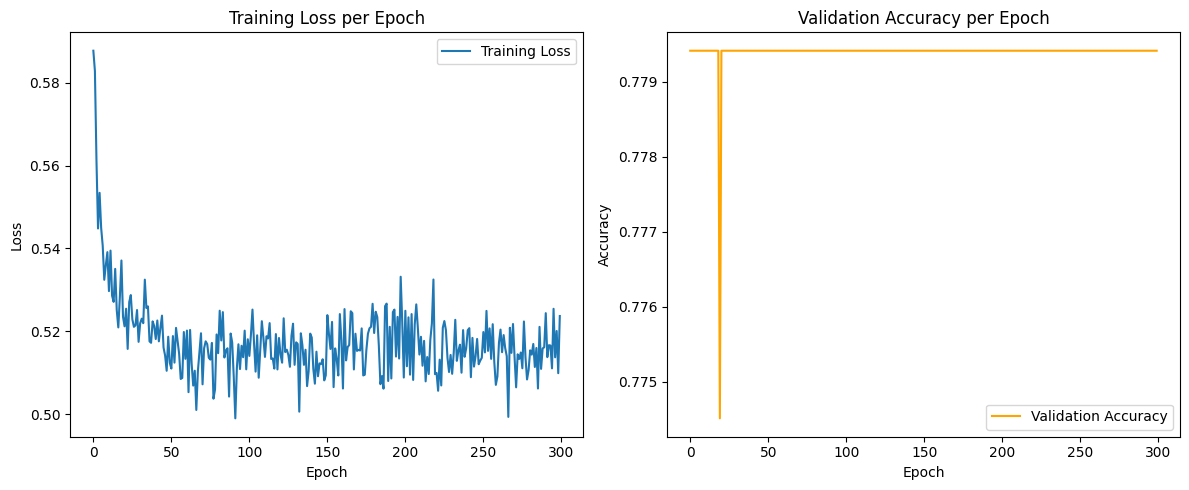

In [21]:
# --- 7. Visualization ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()